# 🚀 Original Meta Networks on Omniglot

**Welcome to this hands-on tutorial!** 👋

This notebook demonstrates the **original Meta Networks** algorithm for few-shot learning on Omniglot. Unlike gradient-based methods (MAML) or metric-based approaches (Embedding-based Meta Networks), Original Meta Networks learn to **directly generate classifier parameters** (weights and biases) from support set examples.

## 🎯 What You'll Learn

This tutorial covers the **true Meta Networks** approach from the original paper (Munkhdalai & Yu, 2017):
- 🧠 How one neural network learns to predict another network's parameters
- ⚡ Single forward pass inference (no gradient adaptation needed)
- 🎯 Weight and bias generation from support set embeddings
- 📊 Comparison with MAML and Embedding-based variants

### ✨ Key Features:
- **5-way 1-shot learning**: Classify 5 characters with only 1 example per class
- **Weight prediction**: Meta-learner predicts FC layer weights W [64×5] and biases b [5]
- **Original architecture**: Uses U, V matrices and embedding vector e
- **One-shot generation**: Classifier weights generated in single forward pass
- **Shared components**: Uses same EmbeddingNetwork as other implementations

### 📊 Dataset:
Omniglot: 1,623 handwritten characters from 50 alphabets, 20 examples each. The "MNIST of few-shot learning"!

> **Note**: Dataset visualization and exploration are covered in detail in `embedding_based_meta_network.ipynb`. This notebook focuses on the Original Meta Networks algorithm.

### 📖 References:
- [Meta Networks Paper](https://arxiv.org/abs/1703.00837) - Munkhdalai & Yu, 2017
- [Omniglot Dataset](https://github.com/brendenlake/omniglot)

---

Let's dive in! 🏊‍♂️

## 1️⃣ Import Dependencies

Import necessary libraries for Original Meta Networks, data processing, and visualization. 📦

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append('..')  # Ensure the current directory is in the path

# Import our custom modules
from algorithms.original_meta_network import OriginalMetaNetwork, train_original_meta_network, evaluate_original_meta_network
from utils.load_omniglot import OmniglotDataset, OmniglotTaskDataset
from evaluation.eval_visualization import plot_evaluation_results, plot_training_progress

## 2️⃣ Dataset Classes 🗂️

We use the same dataset utilities as other meta-learning algorithms in this repository:

### OmniglotDataset
Loads all character classes from Omniglot. Each character has ~20 handwritten examples. 📝

### OmniglotTaskDataset
Generates N-way K-shot learning tasks by randomly sampling classes and splitting into support/query sets. 🎲

**Task Structure:**
- **Support Set** 📚: K examples per class (for generating classifier parameters)
- **Query Set** 🧪: Additional examples per class (for testing generated classifier)

> **Note**: For detailed dataset exploration and visualization, see `embedding_based_meta_network.ipynb` or `maml_on_omniglot.ipynb`.

## 3️⃣ Test Original Meta Network Architecture 🧠

Let's verify that our Original Meta Network implementation works correctly with dummy data!

**Original Meta Networks Architecture:** 🏗️

```
Input Images → EmbeddingNetwork → Feature Embeddings
                                         ↓
Support Embeddings → MetaLearner (U, V, e) → Class Representations
                                         ↓
                    Weight Generator → W [64×5]
                    Bias Generator → b [5]
                                         ↓
Query Embeddings @ W + b → Logits → Predictions
```

**Key Components:**
- **EmbeddingNetwork**: Shared CNN feature extractor (from `embedding_network.py`)
- **MetaLearner**: Learns U, V, e matrices + weight/bias generators
- **Weight Generation**: Predicts actual FC layer weights W [embedding_dim × num_classes]
- **Bias Generation**: Predicts actual FC layer biases b [num_classes]
- **Classification**: Direct multiplication: `logits = query_embeddings @ W + b`

**Key Difference from Embedding-based variant:**
- ✅ Original: Generates **actual classifier parameters** (W, b)
- 📊 Embedding-based: Generates **embeddings for metric learning**


In [2]:
# Create and test Original Meta Network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_model = OriginalMetaNetwork(embedding_dim=64, hidden_dim=128, num_classes=5).to(device)

print(f"✅ Original Meta Network created on {device}")
print(f"\n📐 Architecture Details:")
print(f"   Embedding network: {test_model.embedding_network.fc.out_features} dims (no classification layer)")
print(f"   Meta-learner U matrix: {test_model.meta_learner.U.shape}")
print(f"   Meta-learner V matrix: {test_model.meta_learner.V.shape}")
print(f"   Meta-learner e vector: {test_model.meta_learner.e.shape}")
print(f"\n🎯 Meta-learner output:")
print(f"   Weight generator: hidden_dim → embedding_dim (creates W columns)")
print(f"   Bias generator: hidden_dim → 1 (creates b values)")
print(f"   Final output: W [64×5] and b [5] for classification!")
print(f"\n✅ Total trainable parameters: {sum(p.numel() for p in test_model.parameters() if p.requires_grad):,}")
print("\n💡 Key: Meta-learner predicts actual classifier parameters!")
print("Ready to train! 🚀")

✅ Original Meta Network created on cuda

📐 Architecture Details:
   Embedding network: 64 dims (no classification layer)
   Meta-learner U matrix: torch.Size([128, 64])
   Meta-learner V matrix: torch.Size([128, 64])
   Meta-learner e vector: torch.Size([128])

🎯 Meta-learner output:
   Weight generator: hidden_dim → embedding_dim (creates W columns)
   Bias generator: hidden_dim → 1 (creates b values)
   Final output: W [64×5] and b [5] for classification!

✅ Total trainable parameters: 309,057

💡 Key: Meta-learner predicts actual classifier parameters!
Ready to train! 🚀


### 🧪 Test Forward Pass

Verify the architecture works correctly with dummy data before training:

In [3]:
# Test with dummy data to verify the architecture
print("🧪 Testing Original Meta Network with dummy data...\n")

# Create dummy data for 5-way 1-shot task
n_way = 5
k_shot = 1
k_query = 3

dummy_support = torch.randn(n_way * k_shot, 1, 105, 105).to(device)
dummy_support_labels = torch.arange(n_way).to(device)
dummy_query = torch.randn(n_way * k_query, 1, 105, 105).to(device)

print(f"📊 Test Configuration:")
print(f"   Support data: {dummy_support.shape} ({n_way}-way {k_shot}-shot)")
print(f"   Support labels: {dummy_support_labels.shape}")
print(f"   Query data: {dummy_query.shape} ({n_way * k_query} examples)\n")

# Forward pass
with torch.no_grad():
    # Get embeddings
    support_embeddings = test_model.embedding_network(dummy_support)
    query_embeddings = test_model.embedding_network(dummy_query)

    print(f"✅ Embedding network output:")
    print(f"   Support embeddings: {support_embeddings.shape}")
    print(f"   Query embeddings: {query_embeddings.shape}\n")

    # Full forward pass
    logits = test_model(dummy_support, dummy_support_labels, dummy_query)

    print(f"✅ Meta-learner generated classifier and computed logits:")
    print(f"   Logits shape: {logits.shape}")
    print(f"   Expected shape: [{n_way * k_query}, {n_way}] ✓")

    # Check predictions
    predictions = torch.argmax(logits, dim=1)
    print(f"\n✅ Predictions shape: {predictions.shape}")
    print(f"   Sample predictions: {predictions[:5].cpu().tolist()}")

print(f"\n🎉 Success! Original Meta Network is working correctly!")
print(f"💡 The meta-learner successfully generated W [64×{n_way}] and b [{n_way}] for classification!")


🧪 Testing Original Meta Network with dummy data...

📊 Test Configuration:
   Support data: torch.Size([5, 1, 105, 105]) (5-way 1-shot)
   Support labels: torch.Size([5])
   Query data: torch.Size([15, 1, 105, 105]) (15 examples)

✅ Embedding network output:
   Support embeddings: torch.Size([5, 64])
   Query embeddings: torch.Size([15, 64])

✅ Meta-learner generated classifier and computed logits:
   Logits shape: torch.Size([15, 5])
   Expected shape: [15, 5] ✓

✅ Predictions shape: torch.Size([15])
   Sample predictions: [3, 1, 3, 3, 2]

🎉 Success! Original Meta Network is working correctly!
💡 The meta-learner successfully generated W [64×5] and b [5] for classification!


## 4️⃣ Train Original Meta Network 🏋️‍♂️

Time to train our Original Meta Network on the Omniglot training set! The meta-learner will learn to generate effective task-specific classifier parameters! ✨

**Training Configuration:** ⚙️
- 5-way 1-shot tasks 🎯
- 2000 training tasks 📚
- Batch size: 16 tasks per update
- Learning rate: 0.001
- Optimizer: Adam

**How it works:** 🔄
1. **Extract features**: EmbeddingNetwork processes support and query images
2. **Process support set**: MetaLearner computes class representations using U, V, e
3. **Generate parameters**: Weight and bias generators predict W and b
4. **Classify queries**: Use predicted weights: `logits = query_embeddings @ W + b`
5. **Update all components**: Backpropagate through entire pipeline

**Expected Results:** 📈
- Training loss should steadily decrease
- Final loss typically around 0.3-0.8
- Training time: ~10-30 minutes on GPU ⏱️

Grab a coffee! ☕ This might take a while...

In [4]:
# Setup data path and create task dataset
data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_background"

print("Loading Omniglot training dataset...")
omniglot_dataset = OmniglotDataset(data_path)

print("Creating task dataset...")
task_dataset = OmniglotTaskDataset(
    omniglot_dataset,
    n_way=5,
    k_shot=1,
    k_query=15,
    num_tasks=2000
)

task_dataloader = DataLoader(
    task_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=8,
    prefetch_factor=4,
    pin_memory=True
)

# Create Original Meta Network model for training
model = OriginalMetaNetwork(embedding_dim=64, dropout_rates=[0.05 ,0.1 ,0.15, 0.05], hidden_dim=128, num_classes=5)

print(f"\n🧠 Original Meta Network Configuration:")
print(f"   Embedding dimension: 64")
print(f"   Hidden dimension: 128")
print(f"   Number of classes: 5")
print(f"\n📊 Meta-learner components:")
print(f"   U matrix: {model.meta_learner.U.shape} (projects support embeddings)")
print(f"   V matrix: {model.meta_learner.V.shape} (additional transformation)")
print(f"   e vector: {model.meta_learner.e.shape} (base embedding)")
print(f"   Weight generator: Predicts W [64 × 5]")
print(f"   Bias generator: Predicts b [5]")

# Train Original Meta Network
print("\nStarting Original Meta Network training...")
print("💡 Learning to generate good FC layer weights from support sets!")
model, optimizer, losses = train_original_meta_network(
    model=model,
    task_dataloader=task_dataloader,
    learning_rate=0.001
)


Loading Omniglot training dataset...
Loading character paths...


Processing alphabets: 100%|██████████| 30/30 [00:01<00:00, 21.91it/s]


Found 964 character classes
Creating task dataset...

🧠 Original Meta Network Configuration:
   Embedding dimension: 64
   Hidden dimension: 128
   Number of classes: 5

📊 Meta-learner components:
   U matrix: torch.Size([128, 64]) (projects support embeddings)
   V matrix: torch.Size([128, 64]) (additional transformation)
   e vector: torch.Size([128]) (base embedding)
   Weight generator: Predicts W [64 × 5]
   Bias generator: Predicts b [5]

Starting Original Meta Network training...
💡 Learning to generate good FC layer weights from support sets!
Using device: cuda
Starting Original Meta Network training...
Learning rate: 0.001
Optimizer: Adam
Meta-learner parameters: U (torch.Size([128, 64])), V (torch.Size([128, 64])), e (torch.Size([128]))


Training:  80%|████████  | 100/125 [02:09<00:25,  1.02s/it, Loss=0.2440, Avg=0.3060, Best=0.3083]

Step 100: Loss=0.6022


Training: 100%|██████████| 125/125 [02:34<00:00,  1.23s/it, Loss=0.3479, Avg=0.2549, Best=0.2510]


Training completed! Final loss: 0.4001


## 5️⃣ Training Progress Visualization 📊

Analyze the training dynamics to ensure the model learned effectively:

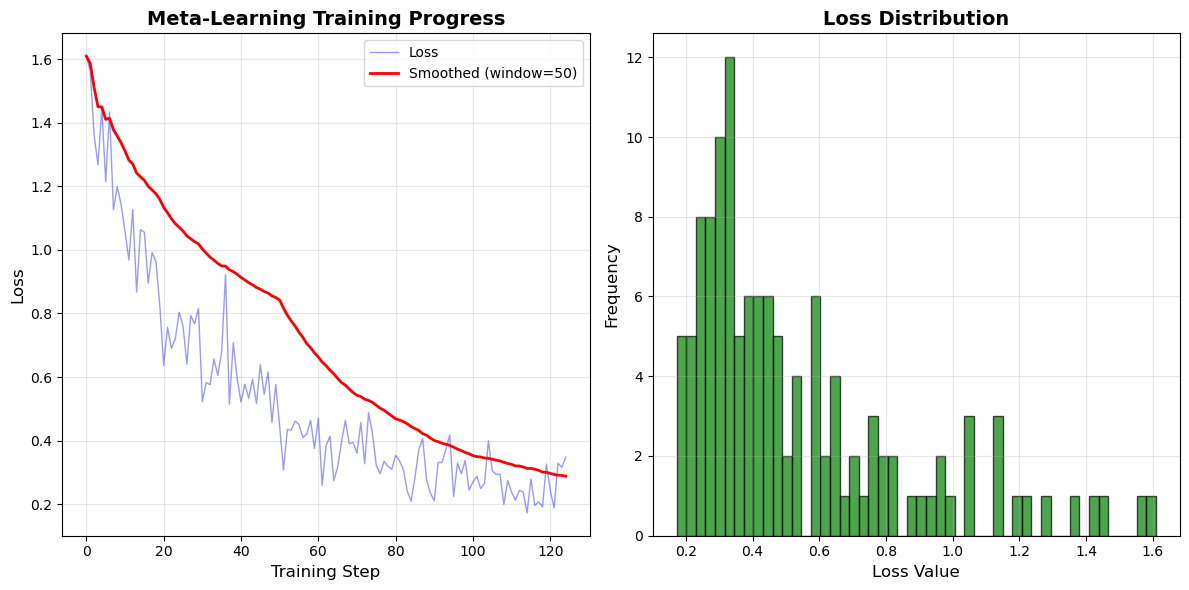


Training Statistics:
   Total steps: 125
   Initial loss (first 10): 1.3365
   Final loss (last 100): 0.4001
   Improvement: 0.9364
   Min loss: 0.1726
   Max loss: 1.6095


In [5]:
# Visualize training progress
plot_training_progress(losses, window_size=50)

## 6️⃣ Evaluate on Test Set 🧪

The moment of truth! Let's evaluate our trained Original Meta Network on completely unseen character classes! 🎭

**Key Difference from MAML:** 🚀
- ❌ MAML: Requires multiple gradient steps for adaptation
- ✅ Original Meta Networks: Direct parameter generation in single forward pass!

**What we measure:** 📏
- Accuracy using meta-learner predicted weights (W and b)
- No adaptation steps needed - parameters generated instantly!
- Direct generalization to new tasks via learned weight prediction

**Expected Performance (5-way 1-shot):** 🎯
- Accuracy: 80-90% (competitive with MAML!)
- Single forward pass generates complete classifier ⚡
- Meta-learner demonstrates learned parameter generation ability 🧠

> **Note**: Test dataset visualization is covered in other notebooks. This evaluation focuses on measuring the model's generalization performance.

Loading Omniglot evaluation dataset... 📚
Loading character paths...


Processing alphabets: 100%|██████████| 20/20 [00:01<00:00, 19.09it/s]


Found 659 character classes
Creating evaluation task dataset... 🎲

Evaluating Original Meta Network on test set... 🧪
💡 How it works:
   1️⃣ Meta-learner sees support set embeddings
   2️⃣ Processes through U, V, e to get class representations
   3️⃣ Generates FC layer weights W [64×5] and biases b [5]
   4️⃣ Uses predicted parameters to classify query set
   5️⃣ No gradient adaptation needed!



Evaluating: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]



ORIGINAL META NETWORK EVALUATION RESULTS
Tasks Evaluated: 200
Task Structure: 5-way classification

Performance:
   Average Accuracy: 0.8631 ± 0.0907
   Average Loss: 0.3836
   Random Baseline: ~0.2000

Task Distribution:
   Tasks with >50% accuracy: 200/200 (100.0%)
   Tasks with >80% accuracy: 159/200 (79.5%)
   Tasks with >90% accuracy: 87/200 (43.5%)

Generating evaluation plots... 🎨


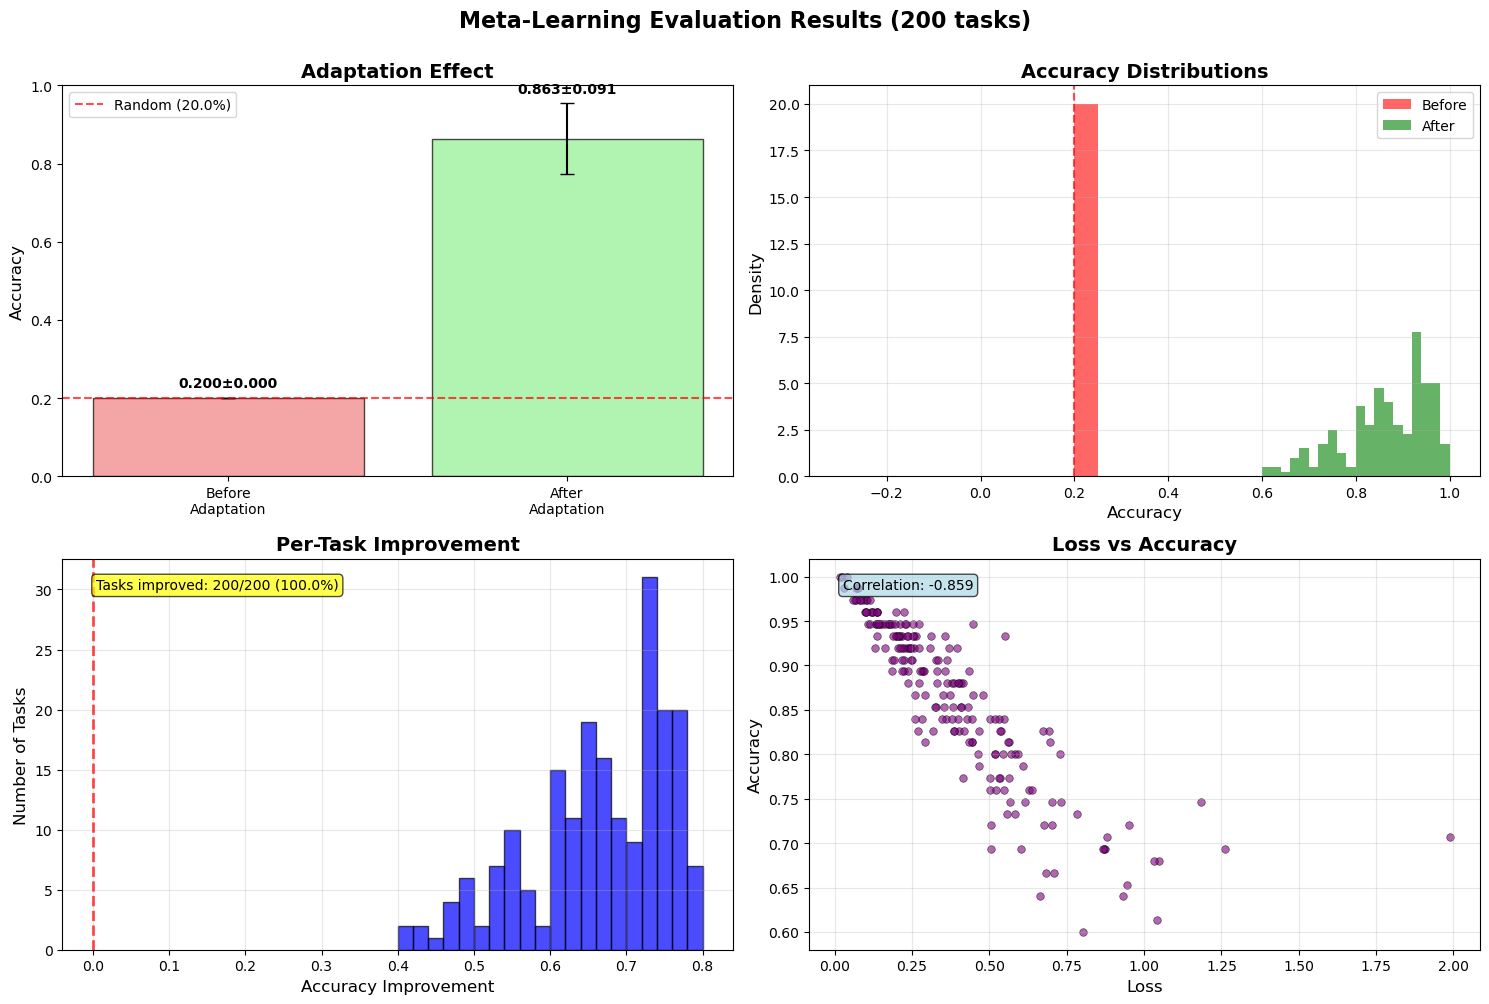


🏆 ORIGINAL META NETWORK PERFORMANCE SUMMARY 🏆
✅ Overall Accuracy: 86.3% ± 9.1%
📉 Average Loss:     0.3836
🎲 Random Baseline:  20.0%

🎊 Congratulations! You've successfully implemented Original Meta Networks! 🎊
💡 Key insight: Meta-learner generates classifier parameters directly from support set!
🚀 One forward pass: support → U,V,e → W & b → classify query!


In [6]:
# Load evaluation dataset 📂
print("Loading Omniglot evaluation dataset... 📚")
eval_data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_evaluation"
eval_dataset = OmniglotDataset(eval_data_path)

print("Creating evaluation task dataset... 🎲")
eval_task_dataset = OmniglotTaskDataset(
    eval_dataset,
    n_way=5,
    k_shot=1,
    k_query=15,
    num_tasks=200
)

eval_dataloader = DataLoader(
    eval_task_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

# Run evaluation 🏃‍♂️
print("\nEvaluating Original Meta Network on test set... 🧪")
print("💡 How it works:")
print("   1️⃣ Meta-learner sees support set embeddings")
print("   2️⃣ Processes through U, V, e to get class representations")
print("   3️⃣ Generates FC layer weights W [64×5] and biases b [5]")
print("   4️⃣ Uses predicted parameters to classify query set")
print("   5️⃣ No gradient adaptation needed!\n")

eval_results = evaluate_original_meta_network(
    model=model,
    eval_dataloader=eval_dataloader,
    num_classes=5,
    verbose=True
)

# Visualize results 📊
print("\nGenerating evaluation plots... 🎨")
improvements = plot_evaluation_results(eval_results)

# Print summary 🎉
print("\n" + "="*70)
print("🏆 ORIGINAL META NETWORK PERFORMANCE SUMMARY 🏆")
print("="*70)
print(f"✅ Overall Accuracy: {eval_results['after_adaptation_accuracy']:.1%} ± {eval_results['after_adaptation_std']:.1%}")
print(f"📉 Average Loss:     {eval_results['all_losses'] and np.mean(eval_results['all_losses']):.4f}")
print(f"🎲 Random Baseline:  {eval_results['random_baseline']:.1%}")
print("="*70)
print("\n🎊 Congratulations! You've successfully implemented Original Meta Networks! 🎊")
print("💡 Key insight: Meta-learner generates classifier parameters directly from support set!")
print("🚀 One forward pass: support → U,V,e → W & b → classify query!")

Loading Omniglot evaluation dataset... 📚
Loading character paths...


Processing alphabets: 100%|██████████| 20/20 [00:01<00:00, 14.82it/s]


Found 659 character classes
Creating evaluation task dataset... 🎲

Evaluating Original Meta Network on test set... 🧪
💡 How it works:
   1️⃣ Meta-learner sees support set embeddings
   2️⃣ Processes through U, V, e to get class representations
   3️⃣ Generates FC layer weights W [64×5] and biases b [5]
   4️⃣ Uses predicted parameters to classify query set
   5️⃣ No gradient adaptation needed!



Evaluating: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]



ORIGINAL META NETWORK EVALUATION RESULTS
Tasks Evaluated: 200
Task Structure: 5-way classification

Performance:
   Average Accuracy: 0.8415 ± 0.1027
   Average Loss: 0.4480
   Random Baseline: ~0.2000

Task Distribution:
   Tasks with >50% accuracy: 200/200 (100.0%)
   Tasks with >80% accuracy: 149/200 (74.5%)
   Tasks with >90% accuracy: 65/200 (32.5%)

Generating evaluation plots... 🎨


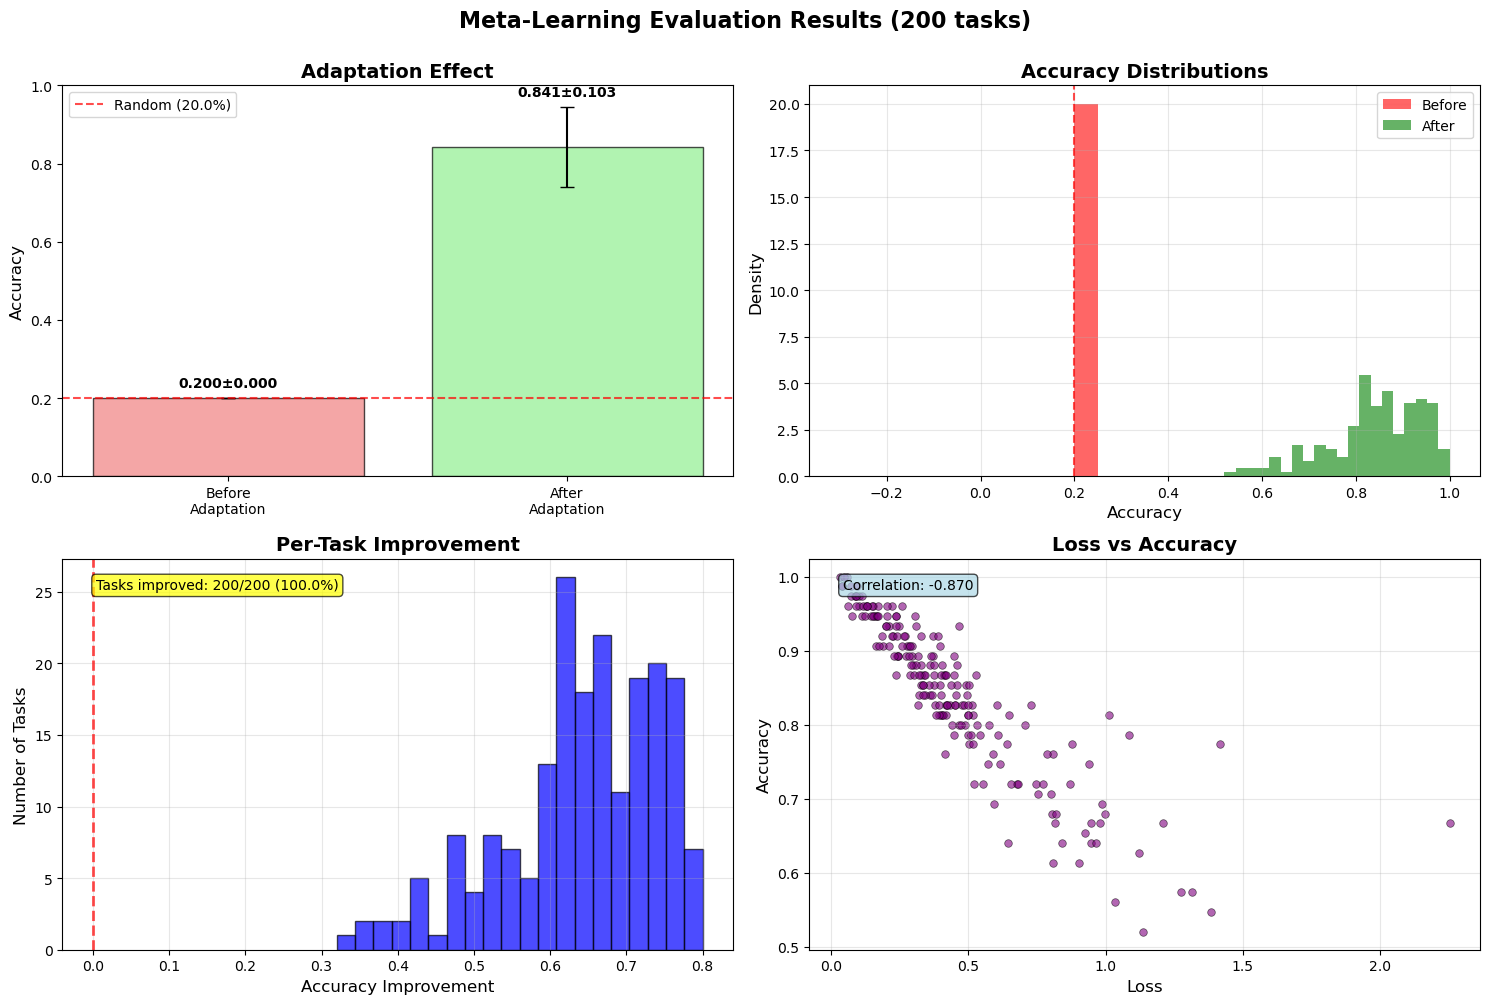


🏆 ORIGINAL META NETWORK PERFORMANCE SUMMARY 🏆
✅ Overall Accuracy: 84.1% ± 10.3%
📉 Average Loss:     0.4480
🎲 Random Baseline:  20.0%

🎊 Congratulations! You've successfully implemented Original Meta Networks! 🎊
💡 Key insight: Meta-learner generates classifier parameters directly from support set!
🚀 One forward pass: support → U,V,e → W & b → classify query!


In [6]:
# Load evaluation dataset 📂
print("Loading Omniglot evaluation dataset... 📚")
eval_data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_evaluation"
eval_dataset = OmniglotDataset(eval_data_path)

print("Creating evaluation task dataset... 🎲")
eval_task_dataset = OmniglotTaskDataset(
    eval_dataset,
    n_way=5,
    k_shot=1,
    k_query=15,
    num_tasks=200
)

eval_dataloader = DataLoader(
    eval_task_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

# Run evaluation 🏃‍♂️
print("\nEvaluating Original Meta Network on test set... 🧪")
print("💡 How it works:")
print("   1️⃣ Meta-learner sees support set embeddings")
print("   2️⃣ Processes through U, V, e to get class representations")
print("   3️⃣ Generates FC layer weights W [64×5] and biases b [5]")
print("   4️⃣ Uses predicted parameters to classify query set")
print("   5️⃣ No gradient adaptation needed!\n")

eval_results = evaluate_original_meta_network(
    model=model,
    eval_dataloader=eval_dataloader,
    num_classes=5,
    verbose=True
)

# Visualize results 📊
print("\nGenerating evaluation plots... 🎨")
improvements = plot_evaluation_results(eval_results)

# Print summary 🎉
print("\n" + "="*70)
print("🏆 ORIGINAL META NETWORK PERFORMANCE SUMMARY 🏆")
print("="*70)
print(f"✅ Overall Accuracy: {eval_results['after_adaptation_accuracy']:.1%} ± {eval_results['after_adaptation_std']:.1%}")
print(f"📉 Average Loss:     {eval_results['all_losses'] and np.mean(eval_results['all_losses']):.4f}")
print(f"🎲 Random Baseline:  {eval_results['random_baseline']:.1%}")
print("="*70)
print("\n🎊 Congratulations! You've successfully implemented Original Meta Networks! 🎊")
print("💡 Key insight: Meta-learner generates classifier parameters directly from support set!")
print("🚀 One forward pass: support → U,V,e → W & b → classify query!")


## 7️⃣ Conclusion & Next Steps

Congratulations on completing this **Original Meta Networks** tutorial! 🎉

### What you've learned: ✨
- ✅ Original Meta Networks algorithm (true paper implementation)
- ✅ How one model predicts another model's parameters
- ✅ Meta-learner architecture: U, V matrices and embedding vector e
- ✅ Weight and bias generation for task-specific classification
- ✅ Model-based vs metric-based vs gradient-based meta-learning

### Key Concepts Mastered: 🧠
- **U Matrix**: Projects support embeddings to hidden space
- **V Matrix**: Additional transformation for meta-learning
- **e Vector**: Base embedding capturing task structure
- **Weight Generator**: Predicts W [embedding_dim × num_classes]
- **Bias Generator**: Predicts b [num_classes]
- **Classification**: logits = query_embeddings @ W + b

### Algorithm Comparison: ⚖️

| Algorithm | Approach | Adaptation              | Speed |
|-----------|----------|-------------------------|-------|
| **Original Meta Networks** | Weight prediction | through Meta Network    | ⚡ Fastest |
| **MAML** | Gradient-based | Multiple gradient steps | 🐢 Slower |
| **Embedding-based Meta Networks** | Metric learning | None (similarity-based) | ⚡ Fast |

### Advantages of Original Meta Networks:
- ✅ **Fastest inference**: Single forward pass, no adaptation loop
- ✅ **Direct parameter generation**: Learns to create good classifiers instantly
- ✅ **Flexible**: Can generate complex decision boundaries
- ✅ **End-to-end**: All components trained jointly

### Next Steps: 🚀
1. **Compare algorithms**: Run MAML, Embedding-based, and Original Meta Networks side-by-side
2. **Experiment with architectures**: Try different hidden dimensions, embedding sizes
3. **Ablation studies**: Test impact of removing U, V, or e components
4. **Advanced variants**: Explore attention-based weight generation
5. **Other datasets**: Apply to miniImageNet, CUB, or custom datasets
6. **Visualize generated weights**: Analyze what the meta-learner learns

### Implementation Files: 📁
- **`algorithms/original_meta_network.py`**: Core algorithm
- **`algorithms/embedding_network.py`**: Shared CNN feature extractor
- **`algorithms/eb_meta_network.py`**: Embedding-based variant
- **`algorithms/maml.py`**: MAML for comparison
- **`docs/ORIGINAL_META_NETWORK_OVERVIEW.md`**: Detailed documentation
- **`docs/META_DROPOUT_IN_META_NETWORKS.md`**: Meta Dropout integration

### Resources: 📚
- [Meta Networks Paper](https://arxiv.org/abs/1703.00837) - Munkhdalai & Yu, 2017
- [Omniglot Dataset](https://github.com/brendenlake/omniglot)
- [MAML Paper](https://arxiv.org/abs/1703.03400) - Finn et al., 2017

---

**Perfect for understanding model-based meta-learning and weight prediction! 🤖💡**

Happy Meta-Learning! 🎓✨
